# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义数据生成器

In [2]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Using TensorFlow backend.


# 测试生成器

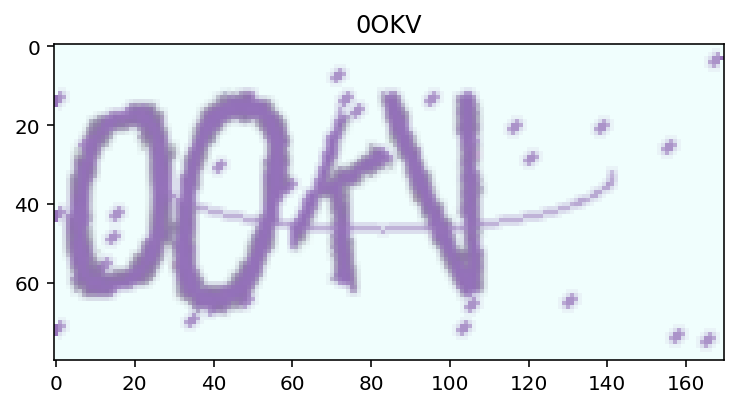

In [3]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [4]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络结构可视化

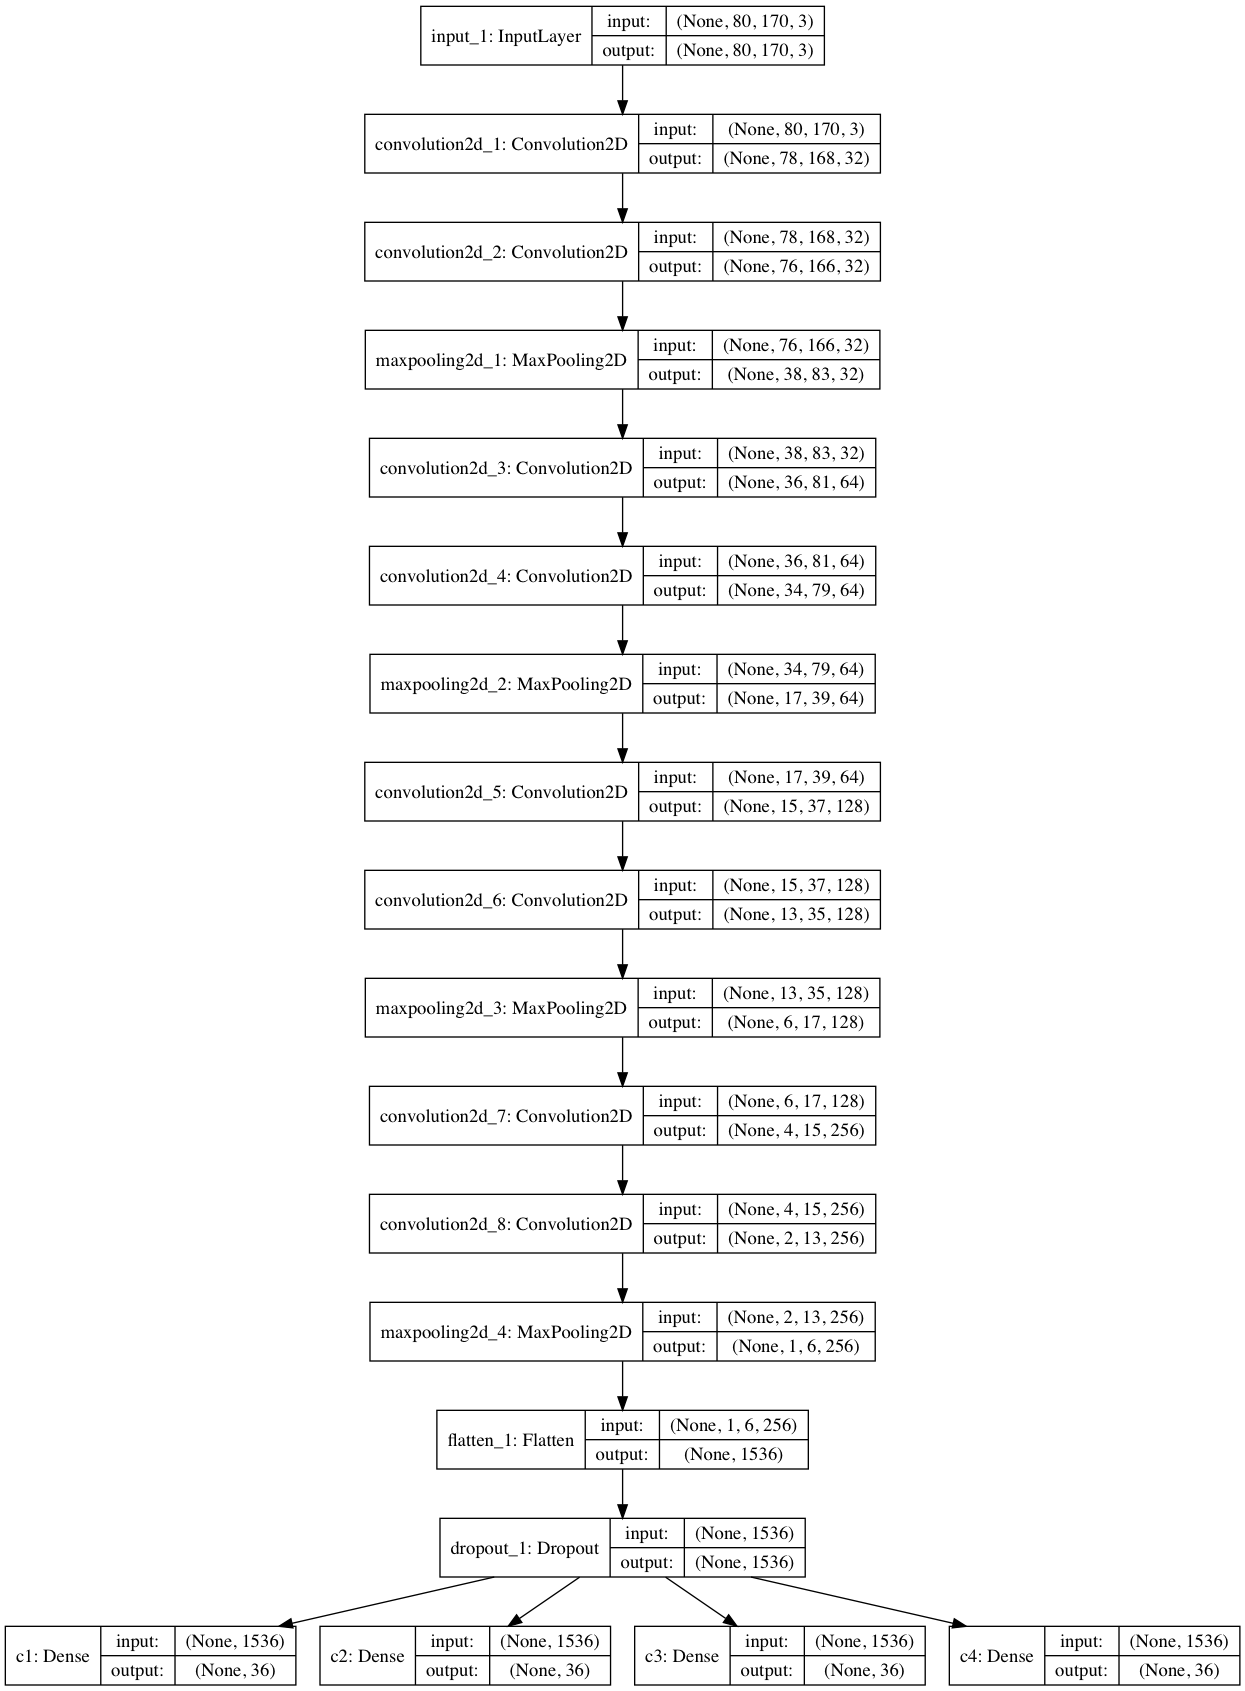

In [5]:
from keras.utils.visualize_util import plot
from IPython.display import Image

plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [6]:
model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5,
                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/5
51200/51200 [==============================] - 127s - loss: 11.7949 - c1_loss: 3.0152 - c2_loss: 2.8573 - c3_loss: 2.9428 - c4_loss: 2.9797 - c1_acc: 0.1671 - c2_acc: 0.2028 - c3_acc: 0.1860 - c4_acc: 0.1785 - val_loss: 3.0524 - val_c1_loss: 0.7782 - val_c2_loss: 0.5730 - val_c3_loss: 0.8024 - val_c4_loss: 0.8988 - val_c1_acc: 0.7594 - val_c2_acc: 0.8109 - val_c3_acc: 0.7742 - val_c4_acc: 0.7586
Epoch 2/5
51200/51200 [==============================] - 125s - loss: 1.7097 - c1_loss: 0.4014 - c2_loss: 0.2837 - c3_loss: 0.4612 - c4_loss: 0.5634 - c1_acc: 0.8728 - c2_acc: 0.9081 - c3_acc: 0.8657 - c4_acc: 0.8464 - val_loss: 0.5816 - val_c1_loss: 0.0885 - val_c2_loss: 0.0693 - val_c3_loss: 0.2037 - val_c4_loss: 0.2201 - val_c1_acc: 0.9680 - val_c2_acc: 0.9805 - val_c3_acc: 0.9328 - val_c4_acc: 0.9297
Epoch 3/5
51200/51200 [==============================] - 125s - loss: 0.7000 - c1_loss: 0.1352 - c2_loss: 0.1087 - c3_loss: 0.2107 - c4_loss: 0.2456 - c1_acc: 0.9587 - c2_acc: 0.9636 

KeyboardInterrupt: 

# 测试模型

(-0.5, 169.5, 79.5, -0.5)

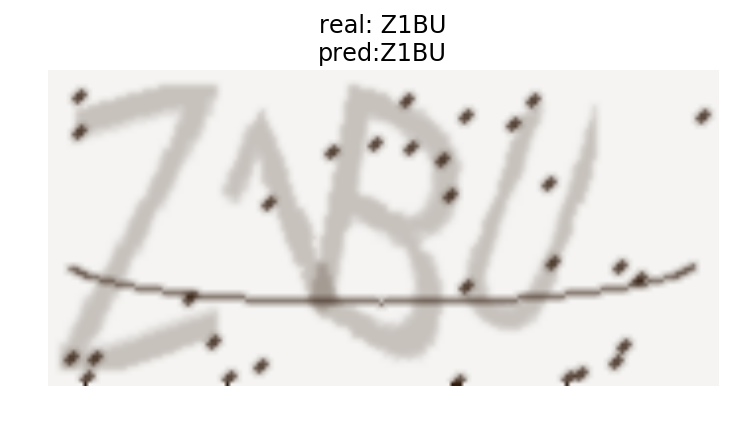

In [19]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [16]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


0.90312499999999996

# 保存模型

In [17]:
model.save('cnn.h5')